In [6]:
# Huggingface diffusersインストール
#!pip install diffusers==0.1.3

# LDMTextToImagePipeline requires the transformers library
#!pip install transformers moviepy
#!apt-get install ffmpeg -y

In [12]:
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

from moviepy.editor import *
from moviepy.video.fx.resize import resize

from diffusers import DiffusionPipeline
from diffusers import UNet2DModel, DDIMScheduler, VQModel

### Pre-trained model set up

In [9]:
# model idの指定
# https://huggingface.co/CompVis/ldm-text2im-large-256
model_id = "CompVis/ldm-text2im-large-256"

# モデルのロード
ldm = DiffusionPipeline.from_pretrained(model_id)

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

### Text to Image

In [10]:
# make folder for outputs
!mkdir outputs_text2img outputs_celebahq

In [13]:
# 入力テキスト(prompt)設定
prompt = 'A robot raising a sign that reads "Recipe"'

# inference
images = ldm(
    [prompt, prompt, prompt, prompt, prompt], # 5枚生成
    num_inference_steps=50, # 予測回数(サンプリング数)
    eta=0.3, # 分散のスケール制御, 1に近づくほどノイズが多くなる(0~1)
    guidance_scale=6 # ガイダンススケール、この値を大きくすると多様性を犠牲にしてサンプルの品質が向上する
    )["sample"]

# サンプリング画像の保存
for idx, image in enumerate(images):
    image.save(f"outputs_text2img/result_{idx}.png")

  0%|          | 0/50 [00:00<?, ?it/s]

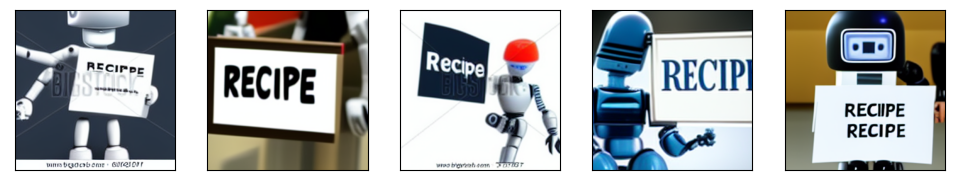

In [14]:
# 生成画像表示
images_path = glob.glob("./outputs_text2img/result_*.png")

fig = plt.figure(figsize=(12, 5))
for i, path in enumerate(images_path):
    ax = fig.add_subplot(1, len(images_path), i+1, xticks=[], yticks=[])
    plt.imshow( np.asarray(Image.open(path)) )

### Faces generator

In [15]:
# model idの指定
# https://huggingface.co/CompVis/ldm-celebahq-256
celebahq_model_id = "CompVis/ldm-celebahq-256"
seed = 12

# 全てのモデルをロード
unet = UNet2DModel.from_pretrained(celebahq_model_id, subfolder="unet")
vqvae = VQModel.from_pretrained(celebahq_model_id, subfolder="vqvae")
scheduler = DDIMScheduler.from_config(celebahq_model_id, subfolder="scheduler")

{'num_train_timesteps'} was not found in config. Values will be initialized to default values.


In [16]:
# GPU使用可否判定
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print('using device:', device)

# モデルをGPUに配置
unet.to(device)
vqvae.to(device)

using device: cuda:1


VQModel(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
          (1): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), strid

In [17]:
# ガウスノイズ生成
generator = torch.manual_seed(seed)
noise = torch.randn(
    (1, unet.in_channels, unet.sample_size, unet.sample_size),
    generator=generator,
).to(device)

In [18]:
# DDIMSchedulerの予測回数設定
scheduler.set_timesteps(num_inference_steps=250)

In [19]:
def save_img(image, filename):
    # process image
    image_processed = image.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.clamp(0, 255).detach().numpy().astype(np.uint8)
    image_pil = Image.fromarray(image_processed[0])

    image_pil.save(filename)

In [22]:
!rm -rf ./outputs_celebahq/*
num = 0

image = noise
for t in tqdm(scheduler.timesteps):
    # 前画像の残差ノイズを予測
    with torch.no_grad():
        residual = unet(image, t)["sample"]
  
    # DDIMSchedulerを使用してx_t-1を予測
    prev_image = scheduler.step(residual, t, image, eta=0.0)["prev_sample"]
  
    # x_t-1 -> x_t
    image = prev_image

    # 生成画像保存
    filename = f"./outputs_celebahq/result_{num:06}.png"
    # VAEを使用して画像をデコード
    with torch.no_grad():
        temp = vqvae.decode(image)
        save_img(temp, filename)
  
    num += 1

100%|██████████████████████| 250/250 [00:20<00:00, 12.05it/s]


In [28]:
# 動画作成
frames = './outputs_celebahq/result_%06d.png'
video = './outputs_celebahq/celebahq.mp4'

!ffmpeg -i {frames} -c:v libx264 -vf "fps=25,format=yuv420p" {video}

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [29]:
# 動画再生
clip = VideoFileClip(video)
clip = resize(clip, height=420)
clip.ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



TypeError: must be real number, not NoneType